In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Covid Greece Visulizations + ARIMA forecast

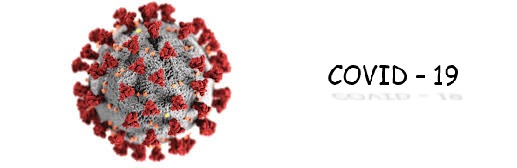

1. <a href="#import">Imports</a>

2. <a href="#eda">Exploratory data analysis (EDA)</a>
 
3. <a href="#greece">Greece Cases</a>

4. <a href="#countries">Greece, Italy, Albania and Turkey</a>

5. <a href="#CASES">Cases Fatalities Rate</a>

6. <a href="#AR">AR, ARIMA and Holt-Winters’ models</a>
 
7. <a href="#ARIMA">Define ARIMA terms</a>

8. <a href="#fit">Model fitting and Evaluation</a>

9. <a href="#Referencees">References</a>



*** These datasets constitute an opportunity to explore our understanding of  disease transmission, and the components that we can observe,understand and control to address the spread of disease and its social, economical impacts. <font size="3">BUT # it goes without saying</font>, in real life diseases are affected by thousends of factors, and thats why the below machine learning techniques inevitably fall from the complexities in real desease transmition.  **
* I hope this notebook will be a valuable and informative resource for everyone.

 # <div id="import"> Imports </div>

In [ ]:
import datetime as dt
import warnings
import matplotlib.pyplot as plt
import datetime as dt 
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)
warnings.warn('ignore')

from matplotlib.dates import DateFormatter
from datetime import timedelta, date
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error


 # <div id="eda">Exploratory data analysis (EDA) </div> 
** A glimpse in the dataset,**

In [ ]:
train_set = pd.read_csv(r"../input/covid19-global-forecasting-week-3/train.csv", parse_dates=['Date'])
print(train_set.head())
print(train_set.describe())

** Spliting the date-time for further analyses, **

In [ ]:
#split column Date into day | month | Year
train_set['Day'] = pd.to_datetime(train_set["Date"]).dt.day
train_set['Month'] = pd.to_datetime(train_set["Date"]).dt.month
train_set['Year'] = pd.to_datetime(train_set["Date"]).dt.year

print(train_set.head())

**Searching for NaNs values,**

In [ ]:
#preprocess 
train_set.isna().sum()

** The dataset has 13376 nan values in 'Province_State' feature. Below we see the countries where  'Province_State' isn't missing.**

In [ ]:
#countries with  Province State
countries_with_Province_State = train_set[train_set['Province_State'].isna()==False]['Country_Region'].unique()
print(countries_with_Province_State)

# <div id="greece">Greece Cases </div> 


**Focusing on Greece,**

In [ ]:
#create df only with Greece 
greece= train_set[train_set.Country_Region  == 'Greece'  ]
#drop feature 'province_state' because of Nan values
greece.drop(['Province_State'],axis=1,inplace=True) 
print(greece)

In [ ]:
#specify the form of the dates
date_form= DateFormatter("%m-%d")


fig, ax1 = plt.subplots(1,2,figsize=(18,5)) 
#some explanaition here : ax1[0] and ax1[1] stands for plot 0 & 1 respectively  
ax1[1].plot(greece["Date"],greece["Fatalities"]  , color='r')
ax1[1].xaxis.set_major_formatter(date_form)
ax1[1].set_xlim([ greece["Date"].min(), greece["Date"].max()+timedelta(days=5) ])
ax1[1].set_xlabel('Date',size=12)
ax1[1].set_ylabel('Fatalities',size=12)
ax1[1].set_title('Fatalities in Greece during the \n period: {}  to {} '.format(greece["Date"].min() , greece["Date"].max() ) , size=15)

ax1[0].plot(greece["Date"],greece["ConfirmedCases"] )
ax1[0].xaxis.set_major_formatter(date_form)
ax1[0].set_xlim([ greece["Date"].min(), greece["Date"].max()+timedelta(days=5) ])
ax1[0].set_xlabel('Date' , size=13 )
ax1[0].set_ylabel('ConfirmedCases',size=12)
ax1[0].set_title('ConfirmedCases in Greece during the \n period: {}  to {}'.format(greece["Date"].min(),greece["Date"].max()), size=15)


# <div id="countries">Greece, Italy, Albania and Turkey </div> 

**We calculate the frequencies of the infected population for each country in order to make comparisons,**

In [ ]:
# Comparison with other countries 
# Italy population 60480000  
# Turkey population 80810000
# Greece population 10740000
# Albania population 2863000


Greece_population =10740000
Turkey_population =80810000
Italy_population = 60480000 
Albania_population= 2863000

total_greece_confirmed = train_set[(train_set['Country_Region']=='Greece' )& (train_set['ConfirmedCases']!=0)]
total_italy_confirmed = train_set[(train_set['Country_Region']=='Italy' )& (train_set['ConfirmedCases']!=0)]
total_turkey_confirmed = train_set[(train_set['Country_Region']=='Turkey' )& (train_set['ConfirmedCases']!=0)]
total_albania_confirmed = train_set[(train_set['Country_Region']=='Albania' )& (train_set['ConfirmedCases']!=0)]


total_greece_confirmed['pop_freq'] = total_greece_confirmed.ConfirmedCases/ Greece_population  * 100
total_italy_confirmed['pop_freq'] = total_italy_confirmed.ConfirmedCases/ Italy_population  * 100
total_turkey_confirmed['pop_freq'] = total_turkey_confirmed.ConfirmedCases/ Turkey_population  * 100
total_albania_confirmed['pop_freq'] = total_albania_confirmed.ConfirmedCases/ Albania_population  * 100


In [ ]:
#plot the cases for each country and remark the first cases
plt.figure(figsize=(15,8))
plt.plot(total_greece_confirmed['Date'] ,total_greece_confirmed['pop_freq'] , 'b') 
plt.axvline(total_greece_confirmed['Date'].values[0] , 0 , linestyle='--',color='b')

plt.plot(total_italy_confirmed['Date'] , total_italy_confirmed['pop_freq'] , 'y')
plt.axvline(total_italy_confirmed['Date'].values[0] , 0 , linestyle='--',color='y')

plt.plot(total_turkey_confirmed['Date'], total_turkey_confirmed['pop_freq'],'r')
plt.axvline(total_turkey_confirmed['Date'].values[0] , 0 , linestyle='--',color='r')

plt.plot(total_albania_confirmed["Date"], total_albania_confirmed["pop_freq"], 'orange')
plt.axvline(total_albania_confirmed['Date'].values[0] , 0 , linestyle='--', color='orange')
plt.legend(('Greece cases' , 'Greece first case' , 'Italy cases', 'Italy first case'  ,'Turkey cases' , 'Turkey first case', 'Albania case' , 'Albania first case ') ,fontsize=12)
plt.xlabel('Date' , size= 14)
plt.ylabel('% of Population' , size=14)
plt.title('Infection of the virus from first confirmed case', size=18)
# plt.plot()
plt.show()


# <div id="CASES">Cases Fatalities Rate </div> 

**In order to calculate the case fatality rate **:   $Case Fatality Rate $= $Fatalities \div (Confirmed Cases)$


In [ ]:
#create a new column for case fatality rate

total_greece_confirmed['CFR'] = total_greece_confirmed['Fatalities']/ total_greece_confirmed['ConfirmedCases']
total_greece_confirmed['CFR'].replace([np.inf, -np.inf], 0, inplace=True)
#Lets check mortality 
fig,ax = plt.subplots(  1 ,2 ,figsize=(18,6))
ax[0].plot( total_greece_confirmed['Date'] , total_greece_confirmed['ConfirmedCases'] , 'b')
ax[0].plot(total_greece_confirmed['Date'] , total_greece_confirmed['Fatalities'] , color='red')
ax[0].legend(('Confirmed Cases', 'Deaths') , fontsize=8)
ax[0].set_xlabel('Date',size=13)
ax[0].set_ylabel('Population',size=13)
ax[0].set_title('Mortality in Greece',size=16)

size=[total_greece_confirmed['Fatalities'].max(), total_greece_confirmed['ConfirmedCases'].max()]
#print(total_greece_confirmed['Fatalities'])
#print(total_greece_confirmed['ConfirmedCases'])
colors = ['red', 'yellowgreen']
explode = (0.2, 0) 
ax[1].pie(  size,   colors=colors,explode=explode , labels = ['Fatalities','ConfirmedCases'],autopct='%1.1f%%', shadow=True, startangle=140)
ax[1].set_title('Case fatality rate' ,size=16)


plt.show()

# <div id="AR">AR, ARIMA and Holt-Winters’ models </div> 

**Below we use** :
* autoregressive model $AR(p)$  
* $ARIMA(p,q,d)$   and   
* $Holt’s$ $Exponential$ $Smoothing$ model
Some statistics here :  
 1.  In an autoregression model  $AR(p)$, we forecast the variable of interest using a linear combination of past values of the variable.Thus, an autoregressive model of order $p$ can be written as : 
<font size="4">$$y_t= c + φ_1* y_{t-1} + φ_2 *y_{t-2}  + ... + φ_p *y_{t-p}$$</font>

 2. ARIMA models aim to describe the autocorrelations in the data. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are
* $AR$: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
* $I$: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* $MA$: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
 
* Each of the above components are explicitly specified in the model as a parameter.That is,  
 p : the # of lags, 
 d : the # of  times that the raw observations are differenced (degree of differencing),
 q : the # of the moving average window (MA) 

3.   $Holt’s$ $Exponential$ $Smoothing$ 
The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations — one for the level, one for the trend, and one for the seasonal component. This method takes the next time step as an exponentially weighted linear function of observations at prior time steps, taking trends and seasonality into account. This method is suitable for univariate time series with trend and/or seasonal components.

**We create a dataframe with features **['ConfirmedCases', 'Date']** and we handle the data as TimeSeries. We visualize the fit of the three models in the data and their 7-days predictions. **

In [ ]:


data=total_greece_confirmed[['ConfirmedCases','Date']]
 
model_arima = ARIMA(data['ConfirmedCases'] ,dates=data['Date'], order=(1, 2, 1))
model_fit_arima = model_arima.fit()
yhat_arima = model_fit_arima.predict(len(data), len(data)+7, typ='levels' )


model = AR(data['ConfirmedCases'] , data['Date'])
model_fit = model.fit()
print('Lag: %s'%model_fit.k_ar)
yhat = model_fit.predict(len(data), len(data)+7)

from  statsmodels.tsa.holtwinters import ExponentialSmoothing as Holt
ts = data.set_index('Date')
#smoothing_level = The alpha value of the simple exponential smoothing
#smoothing_slope =The beta value of the Holt’s trend method
fit1 = Holt(ts , trend='add').fit(smoothing_level=0.8, smoothing_slope=0.7, optimized=False) 
yhat_holt = fit1.forecast(7).rename("Holt's linear trend")



plt.figure(figsize=(10,8))
plt.plot(data['Date'],data['ConfirmedCases'], color='blue')
plt.plot(yhat, color='red')
plt.plot(yhat_arima , color='green')
plt.plot(yhat_holt , color='orange')
plt.title(('Predictions of the ARIMA, AR and ExponentialSmoothing models'),size=16)
plt.xlabel('Date',size=12)
plt.ylabel('Confirmed Cases',size=12)
plt.legend(('Real data','AR','ARIMA','ExponentialSmoothing' ),fontsize=12)
plt.show()


# <div id="ARIMA">Define ARIMA terms</div> 

**We split the data in train set-> 36 days  | test set->5 days. (Greece set)**
* In the **train set** we use decomposition methods for extracting useful components from the time series.



In [ ]:
#Split data

#print(total_greece_confirmed)
dataset  = total_greece_confirmed[['Date','ConfirmedCases']]
#set date as index
dataset=dataset.set_index('Date')
x_train = dataset[:'2020-04-01']
x_test =dataset['2020-04-02':]
print(np.shape(x_train))
print(np.shape(x_test))
#Seasonal decomposition using moving averages.
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(dataset, model='additive')
fig,ax = plt.subplots(  4 ,1 ,figsize=(17,8))
ax[0].grid(True)
ax[0].plot(decomposition.observed.values)
ax[0].set_ylabel('Observed',size=12)
ax[1].grid(True)
ax[1].plot(decomposition.trend.values)
ax[1].set_ylabel('Trend',size=12)
ax[2].grid(True)
ax[2].plot(decomposition.seasonal.values)
ax[2].set_ylabel('Seasonal',size=12)
ax[2].hlines(y=0 , xmin=0 , xmax=40, linestyles='--',color='grey')
ax[3].grid(True)
ax[3].plot(decomposition.resid.values)
ax[3].set_xlabel('Days',size=14)
ax[3].set_ylabel('Residuals',size=12)
ax[3].hlines(y=0 , xmin=0 , xmax=40, linestyles='--',color='grey')
plt.subplots_adjust(hspace=0.5)




**We observe a trend-cyrcle in every 7 days and obviously a positive trend (so non-stationary series ).**
* $Tip$ : Occasionally, the values of the time series in a **small** number of periods may be particularly unusual.

**Let's specify through Autocorrelation the term $d$ of the <font size="4"> $order=(p,q,d)$ </font>

In [ ]:
#Forecasting with Arima  model 
#If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA,
#explore the p,q,d 
#term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors
#Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags) 

#define the d (differencing  in ARIMA model )
result = adfuller(x_train.dropna())
#print(result)
#print(type(result))#tuple

result = pd.DataFrame(data=result)

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(13,10))

axes[0, 0].plot(x_train.values)
axes[0, 0].set_title('Original Series')
plot_acf(x_train.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(x_train.diff().values)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(x_train.diff().dropna().values, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(x_train.diff().diff().values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(x_train.diff().diff().dropna().values, ax=axes[2, 1])

# 3nd Diferencing
axes[3, 0].plot(x_train.diff().diff().diff().values)
axes[3, 0].set_title('3nd Order Differencing',size=10)
plot_acf(x_train.diff().diff().diff().dropna().values, ax=axes[3, 1])
plt.subplots_adjust(hspace=0.5)

plt.show()


 



**Looking at the Autocorrelation plots for the 1st ,2nd and 3rd differencing lag. An autocorrelation plot is designed to show whether the elements of a time series are correlated. In the plot of 2nd and 3rd differencing the lags goes into far negative zone fairly quick, so we will set <font size="4"> d=1</font> (even though the series is not perfectly stationary ).**

**For the MA (q) term we look at the ACF plot. An MA term is technically, the error of the lagged forecast. Thas is, how many MA terms are required to remove any autocorrelation. So, in the autocorrelation plot of the differenced series we notice that the first 2 lags are above the significance line. As a result, we fix ** <font size="4">  q as 2.</font>

In [ ]:
#find the AR term 
#plot Partial autocorrelation (autocorrelation between yt and yt–h after removing any linear dependence on y1, y2, ..., yt–h+1 )
#plot parc with 1 differencing
plt.rcParams["figure.figsize"] = (12,6)
plot_pacf(x_train.diff().dropna().values,use_vlines=True ,lags=20,zero=True)
plt.title('Partial Autocorrelation',size=14)
plt.xlabel('lags' , size=12)
plt.ylabel('Correlation',size=12)
plt.xticks(range(0,21))
plt.show()



**Next, for identifying the AR term we plot thr PACF plot.
In the partial autocorrelation plot above, we observe that lags 1 ,2 and 3 are quite significant since is well above the significance line. So we tentatively fix the $p$ as 3.**

In [ ]:
# select term for MA 

arima_model = ARIMA(x_train, order=(3,2,1))
arima_model_fit = arima_model.fit(disp=0)
print(arima_model_fit.summary())

**Next,we display a density plot of the residual error values, suggesting the errors are Gaussian, <font size="4"> but may not be centered on zero.</font> **

In [ ]:
residuals = pd.DataFrame(arima_model_fit.resid)
residuals.plot(kind='kde')
print(residuals.describe())
plt.title('Residuals density ')

**A zero-mean distribution of the residuals reflect a non biased model. In our case the -2.01 mean shows that indeed there is a bias on the prediction.**

# <div id="fit">Model fitting and Evaluation</div> 


In [ ]:
#make predictions 
history = [ x for x in x_train.values]
predictions= list()


for t in range(0,len(x_test)):
    arima_model = ARIMA(history, order=(3,2,1))
    arima_model_fit = arima_model.fit(disp=0)
    output = arima_model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = x_test.iloc[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(x_test, predictions)
print('Test MSE: %.3f' % error)


plt.plot(x_test.values,color='b')
plt.plot(predictions,color='red')
plt.title('Predicted VS Real' ,size=12)
plt.legend(('Real cases','Predicted cases'),fontsize=18)
plt.xlabel('days',size=12)
plt.ylabel('Comfired Cases',size=12)
plt.show()

In [ ]:
#kaggle evaluation metric
from sklearn.metrics import mean_squared_log_error as rmsle
print('RMSLE : {}'.format(rmsle(x_test, predictions)))


# <div id="Referencees">References</div> 

**Books :
*** Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia.

**Online sources** :
* https://matplotlib.org/index.html
* https://www.statsmodels.org/stable/index.html
* https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/



<div id="#">  </div>